# 主に問2前半とLightgbmの解析を扱った部分です

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
%matplotlib inline


#推論にLightGbmを利用
import lightgbm as lgbm


In [68]:
# データの読み込み
from sklearn.datasets import fetch_covtype
data = fetch_covtype()

# データフレームの作成
df_data = pd.DataFrame(data.data, columns=data.feature_names)
df_target = pd.DataFrame(data.target)
df_target -= 1 #n値分類の場合は0~n-1のインデックスじゃないとエラーするので1引く

df_all = pd.concat([df_data, df_target],axis=1).rename(columns={0:'Cover_Type'})


df_all.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Soil_Type_0,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,0.448865,0.051434,0.436074,0.063627,0.005217,0.012952,0.008301,0.021335,0.002749,0.011316,0.000181,0.000308,0.001974,0.056168,0.021359,0.051584,0.030001,0.001031,0.000005,0.004897,0.005890,0.003268,0.006921,0.015936,0.001442,0.057439,0.099399,0.036622,0.000816,0.004456,0.001869,0.001628,0.198356,0.051927,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,1.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,0.497379,0.220882,0.495897,0.244087,0.072039,0.113066,0.090731,0.144499,0.052356,0.105775,0.013442,0.017550,0.044387,0.230245,0.144579,0.221186,0.170590,0.032092,0.002272,0.069804,0.076518,0.057077,0.082902,0.125228,0.037950,0.232681,0.299197,0.187833,0.028551,0.066605,0.043193,0.040318,0.398762,0.221879,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [11]:
df_all['Cover_Type'].value_counts()

1    283301
0    211840
2     35754
6     20510
5     17367
4      9493
3      2747
Name: Cover_Type, dtype: int64

In [69]:
# 学習データ・テストデータ分割
X_train,X_test,Y_train,Y_test = train_test_split(df_all.drop('Cover_Type', axis=1), df_target, test_size = 0.2, stratify=df_target, random_state=1)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)


(464809, 54) (464809, 1)
(116203, 54) (116203, 1)


# ホールドアウト法による評価（レポートには不使用）

In [70]:

# データセット変換
train_set = lgbm.Dataset(X_train, Y_train)
test_set = lgbm.Dataset(X_test, Y_test)


# パラメータ
params = {'task': 'train',                # 学習、トレーニング ⇔　予測predict
          'boosting_type': 'gbdt',        # 勾配ブースティング
          'objective': 'multiclass',      # 目的関数：多値分類、マルチクラス分類
          'metric': 'multi_logloss',      # 分類モデルの性能を測る指標
          'num_class': 7,                 # 目的変数のクラス数
          'learning_rate': 0.05,          # 学習率（初期値0.1）
          'num_leaves': 30,               # 決定木の複雑度を調整（初期値31）
          'min_data_in_leaf': 15,          # データの最小数（初期値20）
         }

# 学習
evaluation_results = {}                                     # 学習の経過を保存する箱
model = lgbm.train(params,                                   # 上記で設定したパラメータ
                  train_set,                                # 使用するデータセット
                  num_boost_round=2000,                     # 学習の回数
                  valid_names=['train', 'valid'],           # 学習経過で表示する名称
                  valid_sets=[train_set, test_set],         # モデル検証のデータセット
                  evals_result=evaluation_results,          # 学習の経過を保存
                  early_stopping_rounds=40,                 # アーリーストッピング
                  verbose_eval=20)                          # 学習の経過の表示(10回毎)

# 最もスコアが良いときのラウンドを保存
optimum_boost_rounds = model.best_iteration

/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 464809, number of used features: 53
[LightGBM] [Info] Start training from score -1.008939
[LightGBM] [Info] Start training from score -0.718264
[LightGBM] [Info] Start training from score -2.788115
[LightGBM] [Info] Start training from score -5.354079
[LightGBM] [Info] Start training from score -4.114268
[LightGBM] [Info] Start training from score -3.510169
[LightGBM] [Info] Start training from score -3.343858
Training until validation scores don't improve for 40 rounds
[20]	train's multi_logloss: 0.62302	valid's multi_logloss: 0.627789
[40]	train's multi_logloss: 0.513509	valid's multi_logloss: 0.519228
[60]	train's multi_logloss: 0.463091	valid's multi_logloss: 0.47003

In [71]:
# テスト
y_pred = model.predict(X_test.drop('Cover_Type', axis=1), num_iteration=model.best_iteration)
y_pred_max = np.argmax(y_pred, axis=1)

# 正解率
acc = sum(Y_test.values.reshape(-1) == y_pred_max) / len(Y_test)
print('accuracy:', acc)

# 特徴量の重要度
importance = pd.DataFrame(model.feature_importance(), index=df_data.columns, columns=['importance'])
display(importance)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/v6/0z_kylj93ll5z4_htn4grf000000gn/T/ipykernel_23705/1589757879.py", line 2, in <module>
    y_pred = model.predict(X_test.drop('Cover_Type', axis=1), num_iteration=model.best_iteration)
  File "/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/pandas/util/_decorators.py", line 331, in wrapper
  File "/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/pandas/core/frame.py", line 5399, in drop
  File "/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/pandas/util/_decorators.py", line 331, in wrapper
  File "/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/pandas/core/generic.py", line 4505, in drop
    def drop(
  File "/Users/sawaki/opt/anaconda3/envs/murat

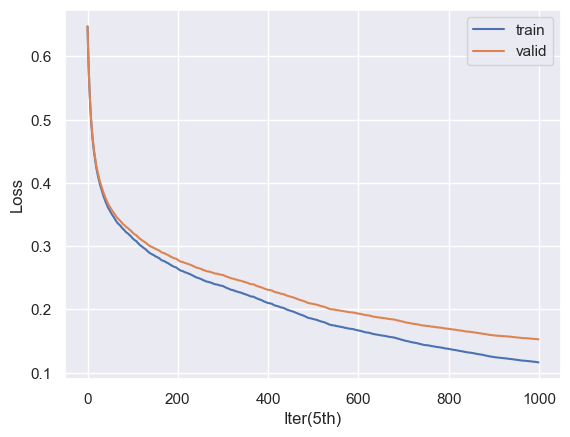

None

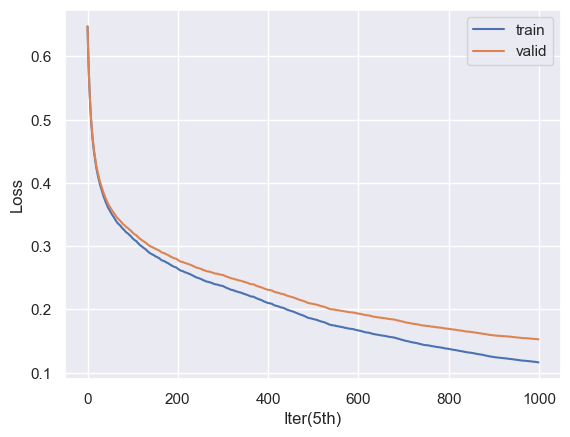

None

In [64]:
# ロスの可視化
sns.set()
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('Loss')
plt.xlabel('Iter(5th)')
plt.legend()
display(plt.show())



# 交差検証法（レポートに使用）

In [72]:
# model格納用
models = []

# 学習データの数だけの数列（0行から最終行まで連番）
row_num = list(range(len(Y_train)))

# 4分割で交差検証
K_fold = StratifiedKFold(n_splits=4, shuffle=True, random_state=10)

# パラメータ
params = {'task': 'train',               
          'boosting_type': 'gbdt',    
          'objective': 'multiclass',    
          'metric': 'multi_logloss',    
          'num_class': 7,               
          'learning_rate': 0.06,         
          'num_leaves': 30,           
          'min_data_in_leaf': 15,          
         }


# 学習（5分割）
for train_idx, eval_idx in K_fold.split(row_num, Y_train):

    # 交差検証用データの引き出し
    X_train_cv = X_train.iloc[train_idx, :]
    y_train_cv = Y_train.iloc[train_idx]
    X_eval_cv = X_train.iloc[eval_idx, :]
    y_eval_cv = Y_train.iloc[eval_idx]
    
    # 学習・検証データセット
    train_set = lgbm.Dataset(X_train_cv, y_train_cv)
    eval_set = lgbm.Dataset(X_eval_cv, y_eval_cv, reference=train_set)

    # 学習
    evaluation_results = {}                  
    model = lgbm.train(params,                                
                      train_set,                             
                      num_boost_round=1200,                  
                      valid_names=['train', 'valid'],         
                      valid_sets=[train_set, eval_set],        
                      evals_result=evaluation_results,        
                      early_stopping_rounds=40,                 
                      verbose_eval=100)                          
    
    # テスト
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred_max = np.argmax(y_pred, axis=1)

    acc = sum(Y_test.values.reshape(-1) == y_pred_max) / len(Y_test)
    print('Testdata accuracy:', acc)
    
    models.append(model) 


/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2271
[LightGBM] [Info] Number of data points in the train set: 348606, number of used features: 53
[LightGBM] [Info] Start training from score -1.008937
[LightGBM] [Info] Start training from score -0.718262
[LightGBM] [Info] Start training from score -2.788124
[LightGBM] [Info] Start training from score -5.353773
[LightGBM] [Info] Start training from score -4.114354
[LightGBM] [Info] Start training from score -3.510215
[LightGBM] [Info] Start training from score -3.343855
Training until validation scores don't improve for 40 rounds
[100]	train's multi_logloss: 0.391491	valid's multi_logloss: 0.407338
[200]	train's multi_logloss: 0.322764	valid's multi_logloss: 0.34391
[300]	train's multi_logloss: 0.281715	valid's multi_logloss: 0.30

/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2264
[LightGBM] [Info] Number of data points in the train set: 348607, number of used features: 53
[LightGBM] [Info] Start training from score -1.008940
[LightGBM] [Info] Start training from score -0.718264
[LightGBM] [Info] Start training from score -2.788127
[LightGBM] [Info] Start training from score -5.354383
[LightGBM] [Info] Start training from score -4.114181
[LightGBM] [Info] Start training from score -3.510122
[LightGBM] [Info] Start training from score -3.343858
Training until validation scores don't improve for 40 rounds
[100]	train's multi_logloss: 0.390922	valid's multi_logloss: 0.404787
[200]	train's multi_logloss: 0.323459	valid's multi_logloss: 0.343006
[300]	train's multi_logloss: 0.282105	valid's multi_logloss: 0.3

/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2266
[LightGBM] [Info] Number of data points in the train set: 348607, number of used features: 53
[LightGBM] [Info] Start training from score -1.008940
[LightGBM] [Info] Start training from score -0.718264
[LightGBM] [Info] Start training from score -2.788127
[LightGBM] [Info] Start training from score -5.354383
[LightGBM] [Info] Start training from score -4.114181
[LightGBM] [Info] Start training from score -3.510122
[LightGBM] [Info] Start training from score -3.343858
Training until validation scores don't improve for 40 rounds
[100]	train's multi_logloss: 0.388904	valid's multi_logloss: 0.405362
[200]	train's multi_logloss: 0.322173	valid's multi_logloss: 0.344349
[300]	train's multi_logloss: 0.281853	valid's multi_logloss: 0.3

/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 348607, number of used features: 53
[LightGBM] [Info] Start training from score -1.008940
[LightGBM] [Info] Start training from score -0.718264
[LightGBM] [Info] Start training from score -2.788081
[LightGBM] [Info] Start training from score -5.353776
[LightGBM] [Info] Start training from score -4.114357
[LightGBM] [Info] Start training from score -3.510218
[LightGBM] [Info] Start training from score -3.343858
Training until validation scores don't improve for 40 rounds
[100]	train's multi_logloss: 0.390826	valid's multi_logloss: 0.403949
[200]	train's multi_logloss: 0.322357	valid's multi_logloss: 0.342631
[300]	train's multi_logloss: 0.282107	valid's multi_logloss: 0.3

In [73]:
# テスト
y_pred = models[2].predict(X_test, num_iteration=model.best_iteration)
y_pred_max = np.argmax(y_pred, axis=1)

# 正解率
acc = sum(Y_test.values.reshape(-1) == y_pred_max) / len(Y_test)
print('accuracy:', acc)

# 特徴量の重要度
importance = pd.DataFrame(model.feature_importance(), index=df_data.columns, columns=['importance'])
display(importance)

accuracy: 0.9401564503498189


,importance
Elevation,33608
Aspect,13507
Slope,7948
Horizontal_Distance_To_Hydrology,20714
Vertical_Distance_To_Hydrology,19589
Horizontal_Distance_To_Roadways,42474
Hillshade_9am,12419
Hillshade_Noon,13206
Hillshade_3pm,12215
Horizontal_Distance_To_Fire_Points,41903


<Axes: title={'center': 'Feature’s importance'}>

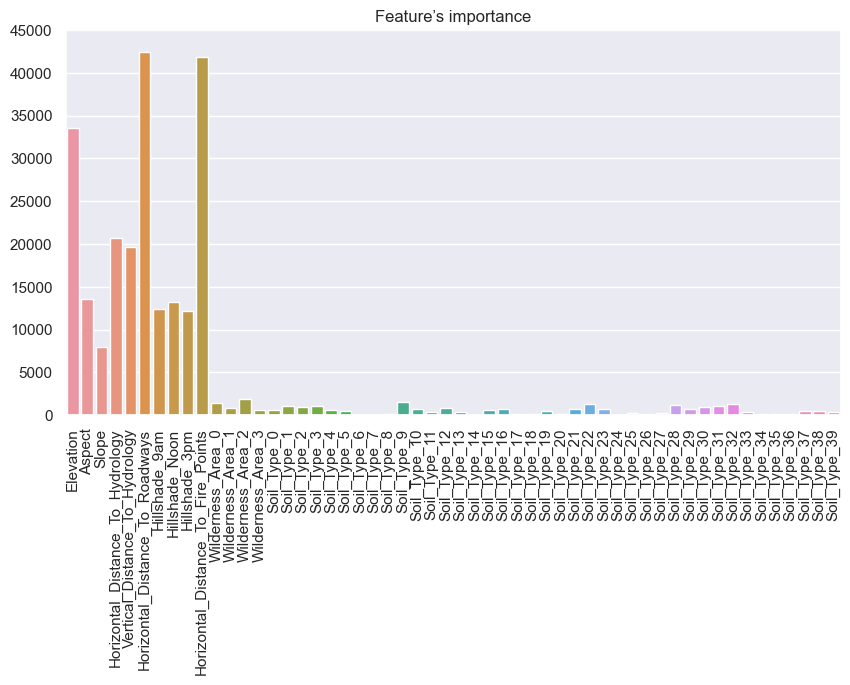

In [99]:
# 特徴量重要度の可視化

plt.figure(figsize=(10, 5))
plt.ylim(0, 45000)
plt.title('Feature’s importance')
g = sns.barplot(x=importance.index.values,y=importance['importance'].values, data=importance, errwidth=0)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
display(g)

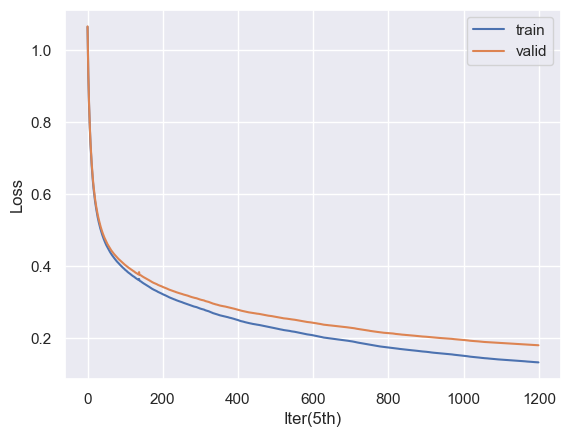

In [20]:
# ロスの可視化
sns.set()
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('Loss')
plt.xlabel('Iter(5th)')
plt.legend()
plt.show()

# 誤ったデータの解析

In [154]:
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
# 予測データの推測確率と正誤リスト

df_pred = pd.DataFrame(y_pred)
df_pred_max = pd.DataFrame(y_pred_max).rename(columns={0:'pred'})
df_correct = pd.DataFrame(Y_test).reset_index().rename(columns={0:'Correct', 'index':'original index'})
tf = pd.DataFrame(Y_test.values.reshape(-1) == y_pred_max).rename(columns={0:'T/F'})


df_pred_TF = pd.concat([df_pred, df_correct],axis=1)
df_pred_TF = pd.concat([df_pred_TF, df_pred_max],axis=1)
df_pred_TF = pd.concat([df_pred_TF, tf],axis=1)

df_pred_F = df_pred_TF[df_pred_TF['T/F'] == False]
df_pred_T = df_pred_TF[df_pred_TF['T/F'] == True]

df_pred_TF

In [33]:
# 間違えたデータ詳細

idx = df_pred_F['original index']
df_all.loc[idx]


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
511829,2975.0,306.0,8.0,277.0,65.0,2507.0,198.0,236.0,178.0,2001.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
406736,3212.0,135.0,3.0,210.0,10.0,2464.0,224.0,238.0,149.0,1410.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
249008,2683.0,45.0,9.0,85.0,2.0,1442.0,223.0,221.0,133.0,604.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8875,2728.0,340.0,9.0,258.0,13.0,1194.0,201.0,227.0,165.0,1986.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
442520,2982.0,315.0,1.0,430.0,61.0,1883.0,215.0,237.0,160.0,789.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188112,3017.0,92.0,5.0,30.0,0.0,1727.0,229.0,231.0,137.0,1766.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
463970,3079.0,343.0,8.0,60.0,10.0,1809.0,204.0,228.0,163.0,446.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
392303,3090.0,170.0,33.0,408.0,23.0,1702.0,222.0,233.0,115.0,1449.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
433919,2970.0,18.0,26.0,323.0,69.0,2063.0,190.0,176.0,111.0,1879.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


,0,1,2,3,4,5,6
0,0,2175,0,0,8,0,137
1,3342,0,82,0,281,74,15
2,0,113,0,51,21,154,0
3,0,0,25,0,0,13,0
4,18,116,4,0,0,4,1
5,1,62,128,26,6,0,0
6,75,22,0,0,0,0,0


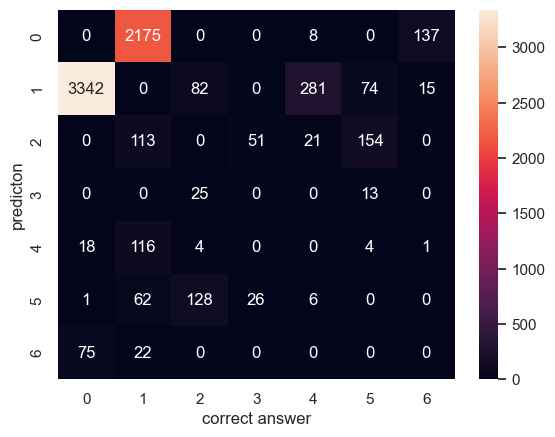

In [34]:
# 何と何を間違えたのか？

df_pred_F[['Correct','pred']]

TF_mat = np.zeros([7,7])
for i in range(7):
    df = df_pred_F[df_pred_F['pred'] == i]
    for j in range(7):
        TF_mat[i,j]=(len(df[df['Correct'] == j]))

display(pd.DataFrame(TF_mat).astype(int))
sns.heatmap(pd.DataFrame(TF_mat).astype(int), annot=True, fmt='d')
plt.xlabel("correct answer")
plt.ylabel("predicton")
plt.show()

In [44]:
# 植生が0/1の土壌タイプ一覧（全データ）
 
pd.options.display.max_columns = None

df_all_cov0 = df_all[df_all['Cover_Type']==0]
df_all_cov1 = df_all[df_all['Cover_Type']==1]

soil_mat = np.zeros([2,40])
for i in range(40):
    typ = 'Soil_Type_{}'.format(i)
    soil_mat[0][i] = len(df_all_cov0[df_all_cov0[typ] == 1])
    soil_mat[1][i] = len(df_all_cov1[df_all_cov1[typ] == 1])

df_soil_cov01 = pd.DataFrame(soil_mat).astype(int)
display(df_soil_cov01)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0,0,0,182,0,0,0,43,161,956,747,2693,2197,0,0,636,214,70,2461,3717,804,25783,35557,11164,125,283,604,43,41911,7644,11863,21358,18148,94,931,14,0,8729,7882,4826
1,0,852,1191,3251,0,912,105,136,986,10803,9077,27278,13258,0,0,1743,957,1659,1490,5207,21,7442,20761,9702,349,2174,451,891,71399,20218,13209,29556,25308,1431,12,42,0,740,358,332


<Axes: title={'center': 'Soil of CoverType 0 (all)'}>

<Axes: title={'center': 'Soil of CoverType 1 (all)'}>

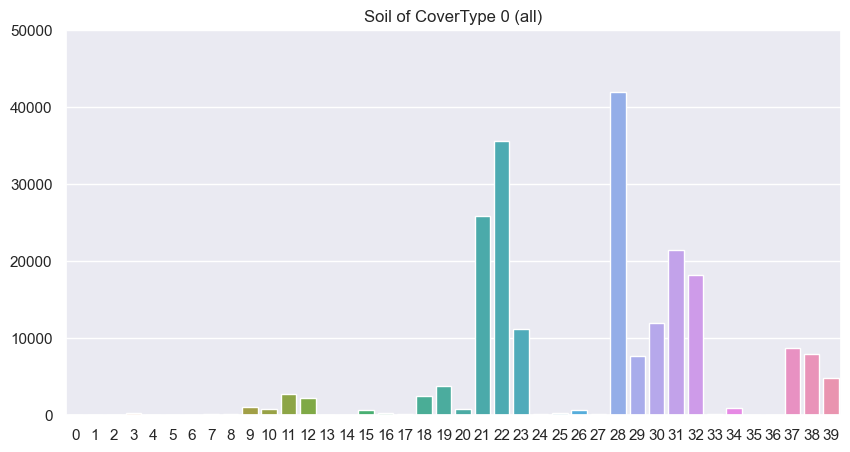

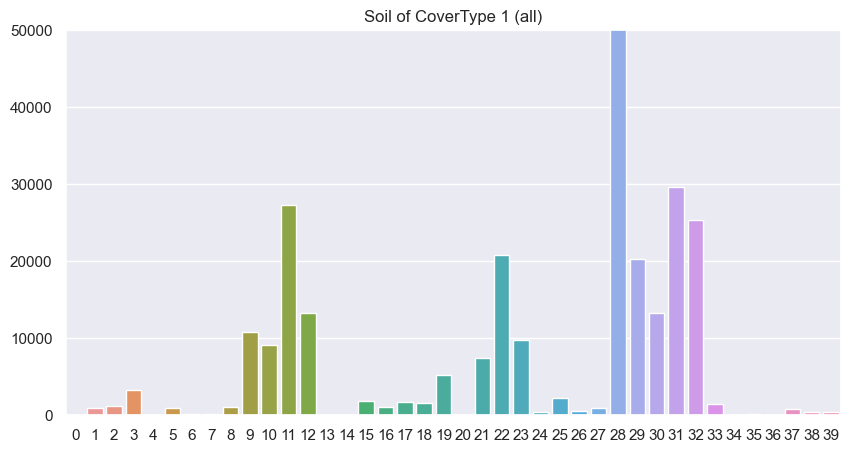

In [45]:
# 土壌タイプの分析：Cov01で全体と誤分類の差はあるか？

plt.figure(figsize=(10, 5))
plt.ylim(0, 50000)
plt.title('Soil of CoverType 0 (all)')
display(sns.barplot(data=df_soil_cov01.loc[0:0], errwidth=0))

plt.figure(figsize=(10, 5))
plt.ylim(0, 50000)
plt.title('Soil of CoverType 1 (all)')
display(sns.barplot(data=df_soil_cov01.loc[1:1], errwidth=0))

In [42]:
# 植生が0/1の土壌タイプ一覧（間違えたデータ）
 
pd.options.display.max_columns = None

idx = df_pred_F['original index']
df_F = df_all.loc[idx]

df_F_cov0 = df_F[df_F['Cover_Type']==0]
df_F_cov1 = df_F[df_F['Cover_Type']==1]

soil_mat = np.zeros([2,40])
for i in range(40):
    typ = 'Soil_Type_{}'.format(i)
    soil_mat[0][i] = len(df_cov0[df_F_cov0[typ] == 1])
    soil_mat[1][i] = len(df_cov1[df_F_cov1[typ] == 1])

df_soil_cov01 = pd.DataFrame(soil_mat).astype(int)
display(df_soil_cov01)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0,0,0,4,0,0,0,0,8,24,28,265,119,0,0,18,13,0,17,51,0,53,297,78,0,8,0,4,1144,176,124,650,289,0,3,1,0,30,27,5
1,0,22,15,28,0,6,0,0,3,72,35,42,31,0,0,17,20,1,10,67,0,148,566,80,1,7,3,0,690,111,81,218,152,1,0,0,0,22,29,10


<Axes: title={'center': 'Soil of CoverType 0 (pred False)'}>

<Axes: title={'center': 'Soil of CoverType 1 (pred Flase)'}>

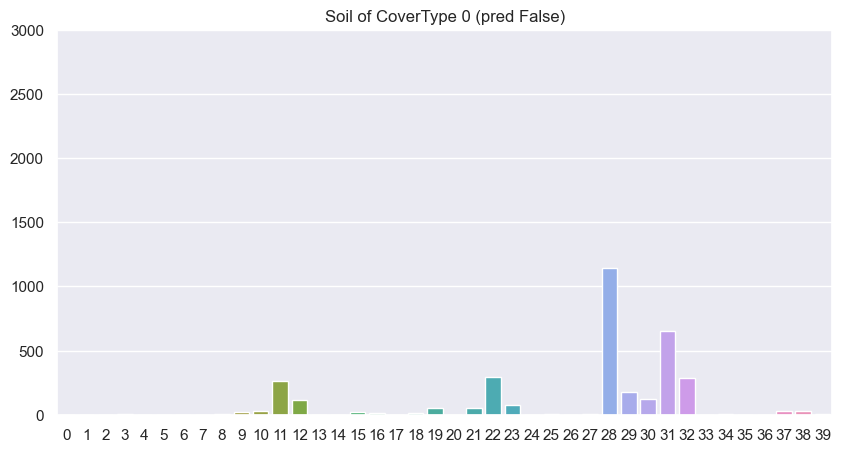

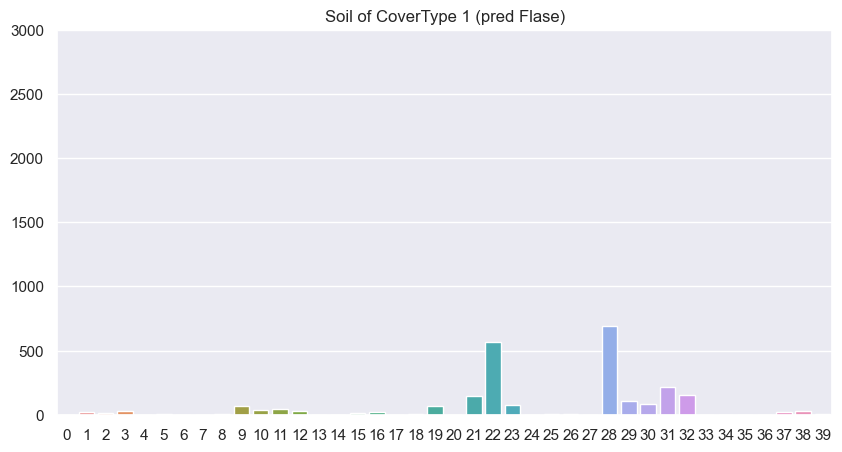

In [43]:
plt.figure(figsize=(10, 5))
plt.ylim(0, 3000)
plt.title('Soil of CoverType 0 (pred False)')
display(sns.barplot(data=df_soil_cov01.loc[0:0], errwidth=0))

plt.figure(figsize=(10, 5))
plt.ylim(0, 3000)
plt.title('Soil of CoverType 1 (pred Flase)')
display(sns.barplot(data=df_soil_cov01.loc[1:1], errwidth=0))

# CoverType0/1に特化したモデル（専門モデル）で検証

In [52]:
df_all_cov01 = df_all[df_all['Cover_Type']<2]
df_target_cov01 = df_target[df_all['Cover_Type']<2]

In [60]:
df_all_cov01

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Soil_Type_0,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,2579.0,132.0,6.0,300.0,-15.0,67.0,230.0,237.0,140.0,6031.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
11,2886.0,151.0,11.0,371.0,26.0,5253.0,234.0,240.0,136.0,4051.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
12,2742.0,134.0,22.0,150.0,69.0,3215.0,248.0,224.0,92.0,6091.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576882,2617.0,29.0,13.0,390.0,128.0,2081.0,215.0,211.0,130.0,592.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
576883,2614.0,21.0,13.0,379.0,125.0,2051.0,211.0,212.0,135.0,618.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
576884,2612.0,17.0,13.0,371.0,123.0,2021.0,208.0,211.0,138.0,644.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
576885,2610.0,16.0,14.0,365.0,110.0,1991.0,208.0,211.0,138.0,671.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [53]:
# 学習データ・テストデータ分割
X_train_cov01, X_test_cov01,Y_train_cov01,Y_test_cov01 = train_test_split(df_all_cov01.drop('Cover_Type', axis=1), df_target_cov01, test_size = 0.2, stratify=df_target_cov01, random_state=1)

print(X_train_cov01.shape, Y_train_cov01.shape)
print(X_test_cov01.shape, Y_test_cov01.shape)

(396112, 54) (396112, 1)
(99029, 54) (99029, 1)


In [58]:
# model格納用
models_cov01 = []

# 学習データの数だけの数列（0行から最終行まで連番）
row_num = list(range(len(Y_train_cov01)))

# 4分割で交差検証
K_fold = StratifiedKFold(n_splits=2, shuffle=True, random_state=10)

# パラメータ
params = {'task': 'train',               
          'boosting_type': 'gbdt',    
          'objective': 'multiclass',    
          'metric': 'multi_logloss',    
          'num_class': 2,               
          'learning_rate': 0.1,         
          'num_leaves': 40,           
          'min_data_in_leaf': 10,          
         }


# 学習（5分割）
for train_idx, eval_idx in K_fold.split(row_num, Y_train_cov01):

    # 交差検証用データの引き出し
    X_train_cv = X_train_cov01.iloc[train_idx, :]
    y_train_cv = Y_train_cov01.iloc[train_idx]
    X_eval_cv = X_train_cov01.iloc[eval_idx, :]
    y_eval_cv = Y_train_cov01.iloc[eval_idx]
    
    # 学習・検証データセット
    train_set = lgbm.Dataset(X_train_cv, y_train_cv)
    eval_set = lgbm.Dataset(X_eval_cv, y_eval_cv, reference=train_set)

    # 学習
    evaluation_results = {}                  
    model = lgbm.train(params,                                
                      train_set,                             
                      num_boost_round=1000,                  
                      valid_names=['train', 'valid'],         
                      valid_sets=[train_set, eval_set],        
                      evals_result=evaluation_results,        
                      early_stopping_rounds=50,                 
                      verbose_eval=100)                          
    
    # テスト
    y_pred = model.predict(X_test_cov01, num_iteration=model.best_iteration)
    y_pred_max = np.argmax(y_pred, axis=1)

    acc = sum(Y_test_cov01.values.reshape(-1) == y_pred_max) / len(Y_test_cov01)
    print('Testdata accuracy:', acc)
    
    models_cov01.append(model) 

/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 198056, number of used features: 49
[LightGBM] [Info] Start training from score -0.849009
[LightGBM] [Info] Start training from score -0.558334
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.313839	valid's multi_logloss: 0.321967
[200]	train's multi_logloss: 0.260049	valid's multi_logloss: 0.273146
[300]	train's multi_logloss: 0.227117	valid's multi_logloss: 0.244239
[400]	train's multi_logloss: 0.203527	valid's multi_logloss: 0.224018
[500]	train's multi_logloss: 0.18214	valid's multi_logloss: 0.205748
[600]	train's multi_logloss: 0.16616	valid's multi_logloss: 0.192585
[700]	train's multi_logloss: 0.151762	valid's multi_logl

/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 198056, number of used features: 49
[LightGBM] [Info] Start training from score -0.849009
[LightGBM] [Info] Start training from score -0.558334
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.313289	valid's multi_logloss: 0.322413
[200]	train's multi_logloss: 0.265036	valid's multi_logloss: 0.278895
[300]	train's multi_logloss: 0.2372	valid's multi_logloss: 0.25461
[400]	train's multi_logloss: 0.210417	valid's multi_logloss: 0.231157
[500]	train's multi_logloss: 0.185205	valid's multi_logloss: 0.208886
[600]	train's multi_logloss: 0.166896	valid's multi_logloss: 0.193499
[700]	train's multi_logloss: 0.151818	valid's multi_loglo

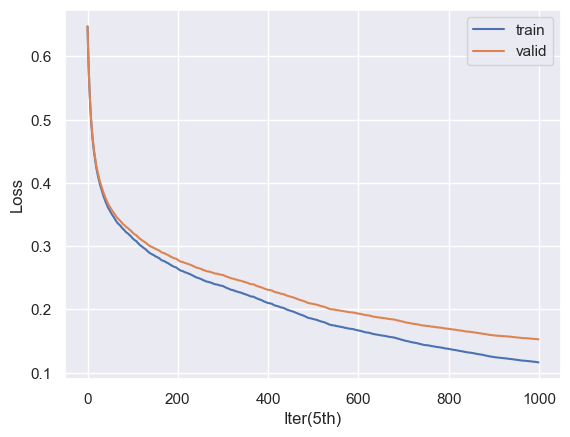

In [59]:
# ロスの可視化
sns.set()
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('Loss')
plt.xlabel('Iter(5th)')
plt.legend()
plt.show()

In [61]:
# テスト
y_pred = models_cov01[0].predict(X_test_cov01, num_iteration=model.best_iteration)
y_pred_max = np.argmax(y_pred, axis=1)

# 正解率
acc = sum(Y_test_cov01.values.reshape(-1) == y_pred_max) / len(Y_test_cov01)
print('accuracy:', acc)

# 特徴量の重要度
importance = pd.DataFrame(model.feature_importance(), index=df_data.columns, columns=['importance'])
display(importance)

accuracy: 0.946722677195569


,importance
Elevation,12430
Aspect,3452
Slope,1558
Horizontal_Distance_To_Hydrology,7132
Vertical_Distance_To_Hydrology,5918
Horizontal_Distance_To_Roadways,14854
Hillshade_9am,2954
Hillshade_Noon,3240
Hillshade_3pm,2788
Horizontal_Distance_To_Fire_Points,14464
